Данная задача очень сильно опирается на пример из keras: examples/mnist_cnn.py. 

Чтобы не ждать сильно долго, я оставил ораничение на выборку в 5000 изображений для тестовых и обучеющих наборов

In [1]:
%matplotlib inline

In [2]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
#"гиперпараметры"
batch_size = 128
num_classes = 10
epochs = 1
img_rows, img_cols = 28, 28

In [4]:
#Та часть изображения, которую нужно ОТРЕЗАТЬ
proportions = (0.0, 0.25, 0.35, 0.5, 0.75)

In [5]:
if K.image_data_format() == 'channels_first':
    input_shape = (1, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 1)

In [6]:
def cut_number(number, proportion):
    number[(1.0 - proportion)*img_rows:] = 0.0

In [7]:
def prepare_datasets(proportions):
    datasets = {}
    for p in proportions:
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
        for x in x_train:
            cut_number(x, p)
        for x in x_test:
            cut_number(x, p)
        if K.image_data_format() == 'channels_first':
            x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)[:5000]
            x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)[:5000]
        else:
            x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)[:5000]
            x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)[:5000]
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train /= 255
        x_test /= 255
        y_train = keras.utils.to_categorical(y_train[:5000], num_classes)
        y_test = keras.utils.to_categorical(y_test[:5000], num_classes)
        datasets[p] = (x_train, y_train), (x_test, y_test)
    return datasets

In [8]:
def plot_examples(datasets):
    f, axes = plt.subplots(1,len(proportions), figsize=(5*len(proportions), 5))
    for i, p in enumerate(proportions):
        axes[i].imshow(datasets[p][0][0][np.random.randint(0, 1000)].reshape(28,28))
    f.tight_layout()

In [9]:
def generate_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                    activation='relu',
                    input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
    return model

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


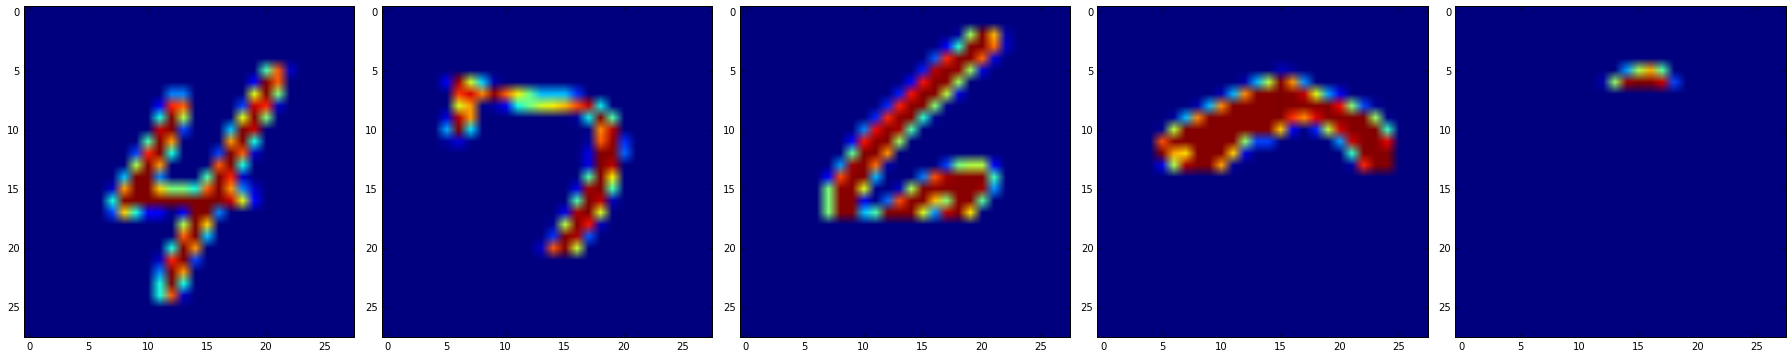

In [10]:
datasets = prepare_datasets(proportions)
plot_examples(datasets)

In [11]:
models = {}
loss = {}
pres = {}
for p in proportions:
    models[p] = generate_model()

In [12]:
for p in proportions:
    print("training for %d %% image"%((1.0-p)*100))
    (x_train, y_train), (x_test, y_test) = datasets[p]
    model = models[p]
    model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=1,
          verbose=0,
          validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    loss[p] = score[0]
    pres[p] = score[1]

training for 100 % image
training for 75 % image
training for 65 % image
training for 50 % image
training for 25 % image


In [55]:
def print_result(proportions, loss, pres):
    #для python 2.x dict.values() возвращает список значений вообще не всегда в том порядке,
    #в котором они хранятся в словаре. Из-за это приходится издеваться 
    loss_list = []
    pres_list = []
    for p in proportions:
        loss_list.append(loss[p])
        pres_list.append(pres[p])
    fig, ax1 = plt.subplots(figsize=(20, 10))
    ax1.plot(proportions, loss_list, 'b-')
    ax1.set_xlabel('Cut image proportion')
    ax1.set_ylabel('loss', color='b')
    ax1.tick_params('y', colors='b')
    ax2 = ax1.twinx()
    ax2.plot(proportions, pres_list, 'r-')
    ax2.set_ylabel('precision', color='r')
    ax2.tick_params('y', colors='r')
    plt.grid(True)
    fig.tight_layout()
    plt.show()

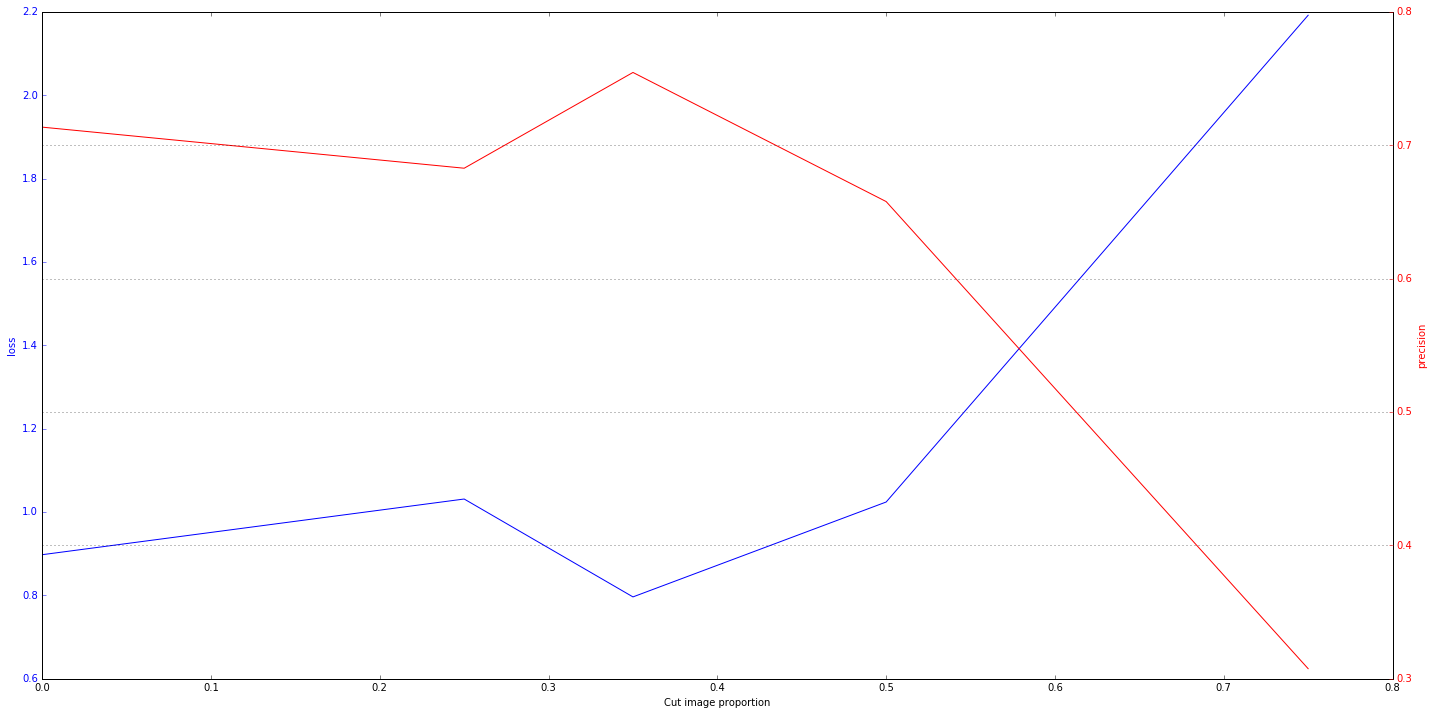

In [56]:
print_result(proportions, loss, pres)